In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
exec(open("startup.py").read())

date : Thu Sep 19 04:17:31 UTC 2019
hostname : tmbgpu
whoami : tmb
pwd : /home/tmb/exp/icdar2019-text



In [3]:
from webdataset import WebDataset

# Datasets

In [4]:
def encode_str(s): return [ord(c)-ord("0")+1 for c in s]
def decode_str(l): return "".join([chr(k+ord("0")-1) for k in l])

encode_str("019")

[1, 2, 10]

- for OCR, ground truth comes as text
- we need to encode/decode strings
- class 0 is reserved for "no class" or "no output"

In [5]:
!tar -tvf data/digits-training.tar | sed 5q

-r--r--r-- bigdata/bigdata 4941 2019-08-28 10:10 0.ppm
-r--r--r-- bigdata/bigdata    3 2019-08-28 10:10 0.txt
-r--r--r-- bigdata/bigdata 6286 2019-08-28 10:10 1.ppm
-r--r--r-- bigdata/bigdata    4 2019-08-28 10:10 1.txt
-r--r--r-- bigdata/bigdata 7630 2019-08-28 10:10 2.ppm
tar: write error


- for large scale training, we need sequential record storage
- a good format for this is simple POSIX tar archives
- the archive contains file.ppm (image) and a corresponding file.txt (transcript)

In [6]:
transforms = [
    lambda x: (torch.tensor(x)[:48,:].float()/255.0).unsqueeze(0),
    lambda s: torch.tensor(encode_str(s)).long()
]

training = WebDataset("data/digits-training.tar", extensions="ppm txt", decoder="l", transforms=transforms)
testing = WebDataset("data/digits-testing.tar", extensions="ppm txt", decoder="l", transforms=transforms)

- we can read tar files with `WebDataset`
- `WebDataset` is an implementation of the PyTorch `Dataset` API
- `WebDataset` can read from local storage, the web, and object stores

torch.Size([1, 48, 88])
tensor([2, 1, 2])


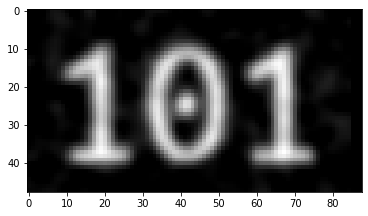

In [7]:
for image, transcript in training:
    imshow(image[0])
    print(image.size())
    print(transcript)
    break

- `WebDataset` lets you iterate over a dataset
- decoding etc. is specified by the `decoder=` and `transforms=` arguments
- existing PyTorch loaders are easy to adapt

# Collation and Data Loaders

In [8]:
def collate4ocr(samples):
    images, seqs = zip(*samples)
    d, w, h = map(max, zip(*[x.shape for x in images]))
    result = torch.zeros((len(images), d, w, h))
    for i, im in enumerate(images):
        d, w, h = im.shape
        result[i, :d, :w, :h] = im
    allwidths = torch.tensor([im.shape[2] for im in images]).long()
    allseqs = torch.cat(seqs).long()
    alllens = torch.tensor([len(s) for s in seqs]).long()
    return (result, allseqs, allwidths, alllens)

- a collation function takes a list of samples and returns a batch
- for OCR, inputs are of variable size
- to create a batch, we have to pack these different sized objects together
- here, we do that by expanding the images to a common maximum

torch.Size([5, 1, 48, 136]) torch.Size([20]) torch.Size([5]) torch.Size([5])
tensor(0.) tensor(0.0039) tensor(1) tensor(10)


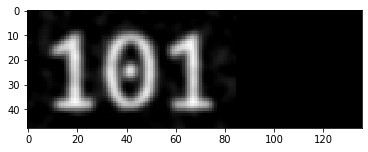

In [9]:
training_dl = DataLoader(training, batch_size=5, collate_fn=collate4ocr)

for images, seqs, images_lens, seqs_lens in training_dl:
    print(images.shape, seqs.shape, images_lens.shape, seqs_lens.shape)
    print(images.min(), images.max(), seqs.min(), seqs.max())
    break
    
imshow(images[0,0])

- collation, batching, and preprocessing is taken care of by PyTorch `DataLoader`
- it can handle some degree of multiprocessing to speed up data loading

# Models

In [10]:
ninput = 48
noutput = 11

def make_model():
    return nn.Sequential(
        layers.Input("BDHW", range=(0, 1), sizes=[None, 1, 48, None]),
        flex.Conv2d(100, 3, padding=1),  # BDWH
        flex.BatchNorm2d(),
        nn.ReLU(),
        layers.Reshape(0, [1, 2], 3), # BDL
        flex.Lstm1(100, bidirectional=True), # BDL
        flex.Conv1d(100, 3, padding=1),
        flex.BatchNorm1d(),
        nn.ReLU(),
        flex.Conv1d(noutput, 1))

model = make_model()
flex.shape_inference(model, images.shape)
model

Sequential(
  (0): Input(BDHW->BDHW torch.float32 (0, 1) cpu [None, 1, 48, None])
  (1): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Reshape(0, [1, 2], 3)
  (5): BDL_LSTM(
    (lstm): LSTM(4800, 100, bidirectional=True)
  )
  (6): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv1d(100, 11, kernel_size=(1,), stride=(1,))
)

# Training

In [11]:
model.cuda()

Sequential(
  (0): Input(BDHW->BDHW torch.float32 (0, 1) cuda:0 [None, 1, 48, None])
  (1): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Reshape(0, [1, 2], 3)
  (5): BDL_LSTM(
    (lstm): LSTM(4800, 100, bidirectional=True)
  )
  (6): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv1d(100, 11, kernel_size=(1,), stride=(1,))
)

- we want to carry out computations on a GPU
- `model.to(device)` will do this for us
- note that the `Input` layer keeps track of the device
- `Input` will automatically move input tensors to the right device
- this makes our training loop independent of device

In [12]:
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

- the optimizer handles updating the model weights based on the gradients
- SGD is sufficient for most uses

In [13]:
images, targets, ilens, tlens = next(iter(training_dl))
print(images.size(), targets.size())
print(ilens)
print(tlens)

torch.Size([5, 1, 48, 136]) torch.Size([20])
tensor([ 88, 112, 136, 112, 112])
tensor([3, 4, 5, 4, 4])


- for sequence learning, input sequences are padded to the longest sequence
- input lengths are passed as a separate tensor
- target sequences are all packed into a single tensor
- target sequence lengths are passed as a separate tensor

In [14]:
optimizer.zero_grad()

- before optimization starts, we need to clear the gradients

-1.6431182622909546 1.7368285655975342


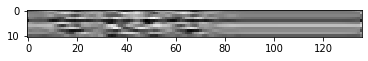

In [15]:
outputs = model.forward(images)
imshow(outputs[0].detach().cpu().numpy())
print(outputs.min().item(), outputs.max().item())

- we can already perform a simple forward pass
- this uses random weights and produces nothing really interesting

0.015139034949243069 0.3973962366580963


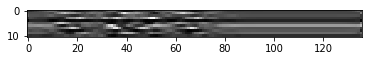

In [16]:
outputs = model.forward(images)
outputs = layers.reorder(outputs, "BDL", "LBD").cpu()
l, b, d = outputs.shape
probs = outputs.log_softmax(2)

imshow(exp(probs[:,0,:].detach().cpu().numpy().T))
print(probs.exp().min().item(), probs.exp().max().item())

- we are going to compute the CTC Loss
- output from the network is in BDL format (what a 1D convolution expects)
- input to CTC loss is expected in LBD format and with log_softmax probabilities

In [17]:
ctc_loss = nn.CTCLoss()
ctc_loss

CTCLoss()

- for OCR, we need to align recognizer output with model output
- in PyTorch, this is handled in a loss function
- this somewhat obscures what is actually going on:
  - forward/backward algorithm
  - EM training

In [18]:
plens = torch.full((b,), l).long()
loss = ctc_loss(probs, targets, plens, tlens)
print(loss)

tensor(73.4546, grad_fn=<MeanBackward0>)


- "computing the CTC loss"
  - perform forward backward alignment
  - treat aligned output as "truth"
  - compute the difference between the aligned output and actual output
  - use that as the delta to back-propagate

In [19]:
loss.backward()
nn.utils.clip_grad_norm_(model.parameters(), 10.0)
optimizer.step()

finishing up the training step:
- propagate deltas backwards
- clip the gradient (to help prevent divergence)
- use the optimizer to update the weights

# Full Training Loops

In [20]:
import matplotlib.pyplot as plt
from IPython import display
    
def update_plot(title, images, probs, losses):
    plt.close("all")
    fig = plt.figure(figsize=(12, 3))
    fig.clf()
    for i in range(3): fig.add_subplot(1, 3, i+1)
    ax1, ax2, ax3 = fig.get_axes()
    ax1.set_title(str(title))
    ax1.imshow(images[0,0].detach().cpu().numpy())
    for i in range(probs.shape[2]):
        ax2.plot(probs[:,0,i])
    ax3.set_yscale("log")
    ax3.set_xscale("log")
    ax3.plot(ndi.gaussian_filter(losses, 10.0, mode="nearest")[::10])
    display.clear_output(wait=True)
    display.display(fig)
    
def print_progress(title, images, probs, losses):
    print("epoch {:2d}   #samples {:8d}   loss {:8.3f}".format(
        epoch, len(losses)*images.size(0), mean(losses[-100:])),
        end="\r", flush=True, file=sys.stderr)

In [21]:
losses = []

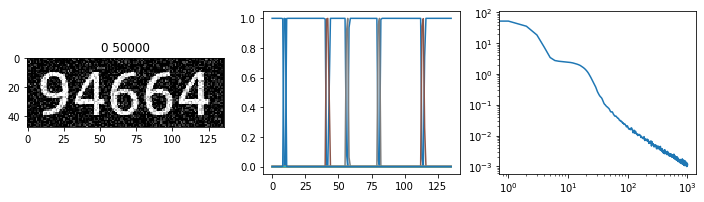

In [22]:
# all the training steps put together
for epoch in range(1):
    i = 0
    for images, targets, ilens, tlens in training_dl:
        optimizer.zero_grad()
        outputs = model.forward(images.cuda())
        b, d, l = outputs.shape
        probs = layers.reorder(outputs, "BDL", "LBD").cpu().log_softmax(2) # LBD
        plens = torch.full((b,), l).long()
        loss = ctc_loss(probs, targets, plens, tlens)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        optimizer.step()
        if len(losses)%100==0:
            update_plot(f"{epoch} {len(losses)*len(images)}", images, probs.detach().exp().numpy(), losses)
display.clear_output(wait=True)

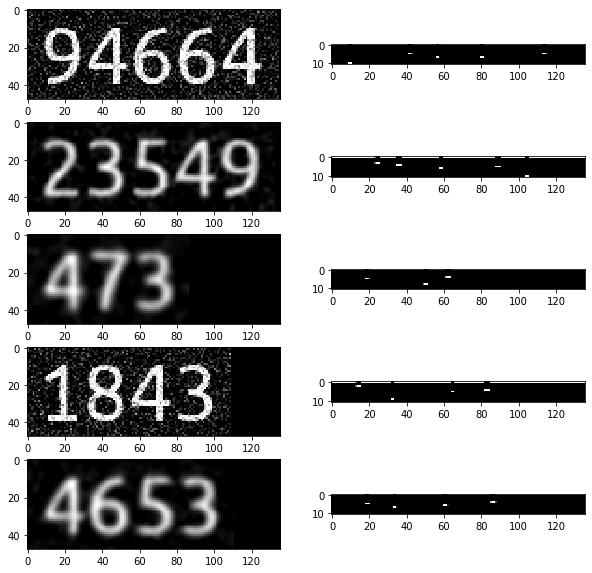

In [23]:
# predictions from the trained model
figsize(10, 10)
for i in range(5):
    subplot(5, 2, 2*i+1); imshow(images[i,0,:,:].detach().numpy())
    subplot(5, 2, 2*i+2); imshow(outputs.softmax(1)[i].detach().cpu().numpy()) # BDL

# Output Decoding

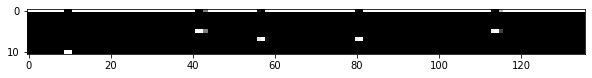

In [24]:
temp = layers.reorder(outputs.detach().cpu(), "BDL", "BLD")
probs = temp.softmax(2)[0].numpy()
assert (abs(probs.sum(1)-1) < 1e-4).all()
imshow(probs.T)

- the model outputs a cost at each location
- costs are transformed into posterior probabilities by `softmax`

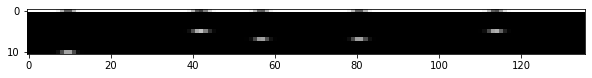

In [25]:
probs = ndi.gaussian_filter(probs, (1.0, 0))
probs /= probs.sum(1)[:,newaxis]
imshow(probs.T)

- LSTMs can "stutter" a little during output
- we eliminate this by a little smoothing and renormalizing
- might want to limit smoothing to probs[1:,:]

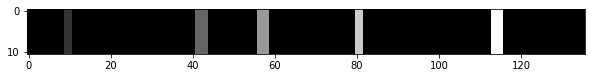

In [26]:
labels, n = ndi.label(probs[:,0]<0.7)
mask = tile(labels[:,newaxis], (1, probs.shape[1]))
imshow(mask.T)

- extract all the areas where there are characters detected and label them
- this is the regions where class 0 has a probability of less than some threshold

In [27]:
ndi.maximum_position(probs, mask, arange(1, amax(mask)+1))

[(9, 10), (42, 5), (58, 0), (81, 7), (114, 5)]

- `scipy.ndimage` has handy morphological operations on masked images
- here: extract the maximum within each labeled region

In [28]:
def simple_decode(probs, sigma=1.0, threshold=0.7, kind=None, full=False):
    probs = asnp(probs)
    assert (abs(probs.sum(1)-1) < 1e-4).all(), \
        "input not normalized; did you apply .softmax()?"
    probs = ndi.gaussian_filter(probs, (sigma, 0))
    probs /= probs.sum(1)[:,newaxis]
    labels, n = ndi.label(probs[:,0]<threshold)
    mask = tile(labels[:,newaxis], (1, probs.shape[1]))
    mask[:,0] = 0
    maxima = ndi.maximum_position(probs, mask, arange(1, amax(mask)+1))
    if not full:
        return [c for r, c in sorted(maxima)]
    else:
        return [(r, c, probs[r, c]) for r, c in sorted(maxima)]


In [29]:
simple_decode(temp.softmax(2)[0], full=True)

[(9, 10, 0.6408016),
 (42, 5, 0.7605884),
 (57, 7, 0.6313493),
 (81, 7, 0.63215834),
 (114, 5, 0.69053006)]

- wrap all of that up into a small function for decoding

In [30]:
decode_str(simple_decode(temp.softmax(2)[0]))

'94664'

## Other Choices for Decoding

- beam search
- finite state transducers and language models
- seq2seq

# End-to-End Recognition

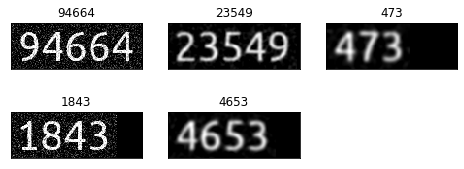

In [31]:
figsize(8, 3)
outputs = model(images).cpu()
probs = layers.reorder(outputs, "BDL", "BLD").softmax(2)
for i in range(5):
    subplot(2, 3,i+1)
    gca().set_title(decode_str(helpers.ctc_decode(probs[i])))
    xticks([]); yticks([])
    imshow(images[i,0,:,:].detach().numpy())

# Trainers and Error Measurements

In [32]:
from helpers import method

In [33]:
class Trainer(object):
    def __init__(self, model): pass
    def set_lr(self, lr): pass
    def train_batch(self, inputs, targets, ilens, tlens): pass
    def train(self, loader, epochs): pass
    def report_progress(self): pass
    def compute_loss(self, outputs, targets): pass
    def probs_batch(self, inputs, ilens): pass
    def predict_batch(self, inputs, ilens): pass
    def errors(self, loader): pass
    
trainer = Trainer(model)

- training logic is commonly wrapped up in objects like these
- the details of each method are dependent on the particular application
- the structure is generally similar between applications

In [34]:
class Trainer(object):
    pass

In [35]:
def device_of(x):
    if isinstance(x, torch.Tensor):
        return x.device
    elif isinstance(x, nn.Module):
        return next(x.parameters()).device
    
device_of(model)

device(type='cuda', index=0)

In [36]:
@method(Trainer)
def __init__(self, model, lr=1e-4):
    self.model = model
    self.ctc_loss = nn.CTCLoss()
    self.losses = []
    self.epoch = 0
    self.last_lr = -1
    self.set_lr(lr)

- keep a reference to the model
- allocate a loss object
- keep track of epoch/losses

In [37]:
@method(Trainer)
def set_lr(self, lr):
    if lr==self.last_lr: return
    self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
    self.last_lr = lr

- in PyTorch, when we change the learning rate, we allocate a new optimizer

In [38]:
@method(Trainer)
def train_batch(self, inputs, targets, ilens, tlens):
    model.train()
    self.optimizer.zero_grad()
    outputs = self.model.forward(inputs).cpu()
    b, d, l = outputs.shape
    logprobs = layers.reorder(outputs, "BDL", "LBD").cpu().log_softmax(2) # LBD
    plens = torch.full((b,), l).long()
    loss = self.ctc_loss(logprobs, targets, plens, tlens)
    self.losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10.0)
    self.optimizer.step()
    self.last_batch = ((inputs, ilens), logprobs, (targets, tlens), loss)
    return loss.detach().item()

- the meat of the training loop
- this takes care of the forward/backward passes, loss computation, and weight update
- one batch only

In [39]:
@method(Trainer)
def train(self, loader, epochs=1, learning_rates=None):
    self.epochs = epochs
    for epoch in range(epochs):
        self.epoch = epoch
        self.set_lr(learning_rates[min(len(learning_rates)-1, self.epoch)])
        for images, targets, ilens, tlens in loader:
            loss = self.train_batch(images, targets, ilens, tlens)
            self.report_progress()
    display.clear_output(wait=True)

- full trainng just takes a data loader as input
- here we set a learning rate schedule by epoch
- often, this also involves evalution over a test set; we skip that there

In [40]:
@method(Trainer)
def report_progress(self):
    (images, _), logprobs, _, loss = self.last_batch
    if not hasattr(self, "last_report"): self.last_report = 0
    if time.time() - self.last_report < 5.0: return
    update_plot(f"epoch:{self.epoch}/{self.epochs} #batches:{len(self.losses)} bs:{len(images)} lr:{self.last_lr}",
                images, logprobs.detach().exp().numpy(),
                self.losses)
    self.last_report = time.time()

- it's useful to break out progess reporting code, since it tends to get messy
- updating by time rather than every n samples leads to more predictable progress tracking
- we're taking advantage of Jupyter's real-time updates

In [41]:
@method(Trainer)
def probs_batch(self, inputs, ilens=None):
    self.model.eval()
    with torch.no_grad():
        outputs = self.model.forward(inputs).detach().cpu()
    logprobs = layers.reorder(outputs, "BDL", "BLD").log_softmax(2)
    return logprobs.exp()

- predict the output probabilities for a batch
- note that we switch to eval mode and turn off gradient computations

In [42]:
@method(Trainer)
def predict_batch(self, inputs, ilens=None):
    probs = self.probs_batch(inputs)
    result = [simple_decode(p) for p in probs]
    return result

- for prediction, we usually compute the actual class
- here, we decode all the output sequences

In [43]:
import editdistance

@method(Trainer)
def errors(self, loader):
    total = 0
    errors = 0
    for inputs, targets, ilens, tlens in loader:
        predictions = self.predict_batch(inputs)
        start = 0
        for p, l in zip(predictions, tlens):
            t = targets[start:start+l].tolist()
            errors += editdistance.distance(p, t)
            total += len(t)
            start += l
    return errors, total

- commonly, there is also a method to evaluate the model over a test set

In [44]:
def irepeat(dl):
    while True:
        yield from dl
        
class ChangeEpoch(object):
    def __init__(self, dl, n):
        self.source = irepeat(dl)
        self.n = n
    def __iter__(self):
        return islice(self.source, 0, self.n)
        

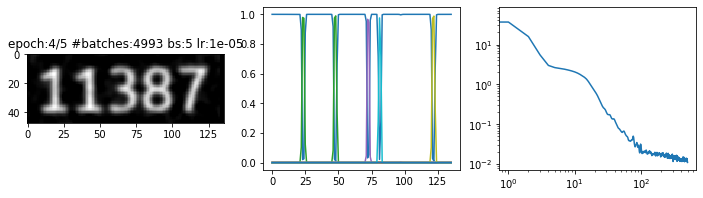

In [45]:
model = make_model()
flex.shape_inference(model, images.shape)
trainer = Trainer(model)
demo_dl = ChangeEpoch(training_dl, 1000) # make it a little shorter for the demo
trainer.train(demo_dl, 5, learning_rates=[1e-3]+[1e-4]*3+[1e-5])

- once you have defined a trainer for a problem class, experimenting with different architectures becomes simple

In [46]:
trainer.predict_batch(images, ilens)

[[10, 5, 7, 7, 5], [3, 4, 6, 5, 10], [5, 8, 4], [2, 9, 5, 4], [5, 7, 6, 4]]

- batch prediction

In [47]:
[decode_str(l) for l in trainer.predict_batch(images, ilens)]

['94664', '23549', '473', '1843', '4653']

- batch prediction and decoding

In [48]:
testing_dl = DataLoader(testing, batch_size=40, collate_fn=collate4ocr)
trainer.errors(testing_dl)

(9, 40069)

- error rate measurement

# Saving

In [49]:
torch.save(model, "temp.pyd")
temp = torch.load("temp.pyd")

- you can load/save models directly
- this is useful for simple checkpointing
- the saved model is very sensitive to source code changes
- it tends not to work well as you change your source code

In [50]:
epoch = trainer.epoch
loss = trainer.losses[-1]
fname = f"lstm-ctc-digits__{epoch:04d}__{loss:.2e}.state.pth"
torch.save(model.state_dict(), fname)

- it is better to save the _state dictionary_
- it's also a good idea to adopt a convention to incorporate epoch/loss into the file name

In [51]:
import glob
def load_latest(model, prefix = "lstm-ctc-digits"):
    fnames = sorted(glob.glob(prefix+"__*__*.state.pth"))
    if fnames == []: return None
    model.load_state_dict(torch.load(fnames[-1]))
    return fnames[-1]

model = make_model()
flex.shape_inference(model, images.shape)
load_latest(model)

'lstm-ctc-digits__0004__1.29e-02.state.pth'

- given good naming conventions, we can get a good idea of how our saved models are doing
- we can also load the latest/best model easily